# Session 6: Temporal Networks and Dynamics

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Session Goals:**
By the end of this session, you will:
1. Understand temporal network representations and metrics
2. Analyze network evolution and structural changes
3. Detect dynamic communities and track their evolution
4. Predict link formation and network changes
5. Apply temporal analysis to financial contagion

**Practical Application:**
Analyze evolving correlation networks during financial crises to detect regime changes and predict contagion

**Duration:** 3 hours

---


## Motivation: Networks Change Over Time

### The Static Network Limitation

**Previous sessions:** Networks as snapshots
- Single adjacency matrix $A$
- Fixed set of nodes and edges
- No temporal dimension

**Reality:** Networks are dynamic!
- Links appear and disappear
- Nodes join and leave
- Communities merge and split
- Structure evolves continuously

### Why Temporal Networks Matter

**1. Financial Crises**

**During crisis:**
- Correlations spike (network densifies)
- Communities break down (contagion spreads)
- New connections form (flight to safety)
- Structure fundamentally changes

**Examples:**
- 2008: Interbank lending froze → network topology changed
- COVID-19: Correlation surge → all stocks moved together
- Crypto crashes: Cross-market contagion intensifies

**2. Market Regimes**

**Different market states:**
- Bull market: Low correlation, strong sectors
- Bear market: High correlation, weak sectors
- Crisis: Extreme correlation, single cluster

**Regime detection:**
- When does structure shift?
- How fast is transition?
- Can we predict regime changes?

**3. Network Evolution**

**Banking networks:**
- New banks enter (network grows)
- Mergers reduce nodes
- Relationships form/dissolve
- Regulation changes structure

**Trade networks:**
- New agreements (edges appear)
- Sanctions (edges disappear)
- Economic integration (community formation)

**Cryptocurrency:**
- New tokens launch daily
- Exchanges open/close
- Correlations shift rapidly

### Key Questions

**1. Structural Change Detection**
- When did network structure change significantly?
- What triggers structural breaks?
- How to quantify change magnitude?

**2. Link Prediction**
- Which edges will form next?
- Which relationships will dissolve?
- Can we forecast network topology?

**3. Dynamic Communities**
- How do communities evolve?
- When do they split or merge?
- Can we track individual node movements?

**4. Temporal Centrality**
- Which nodes are persistently central?
- Who becomes important during crisis?
- How does importance shift over time?

**5. Contagion Dynamics**
- How do shocks propagate through time?
- Does network structure amplify or dampen?
- Can we predict contagion paths?

### Temporal Network Representations

**Three main approaches:**

**1. Snapshot sequence:**
$$\{G_1, G_2, \ldots, G_T\}$$
- Discrete time windows
- Each $G_t$ is a static network
- Easy to implement, but loses intra-window dynamics

**2. Contact sequence:**
$$(i, j, t): \text{edge } (i,j) \text{ active at time } t$$
- Continuous time representation
- Every interaction timestamped
- Captures fine-grained dynamics

**3. Link streams:**
Directed, weighted, time-stamped edges
- Most general representation
- Requires more data
- Captures all information

**We'll focus on snapshot sequences (most common in finance)**


---
## Setup and Imports


In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats, linalg
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# For dynamic community detection
try:
    import community.community_louvain as community_louvain
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'python-louvain', '--break-system-packages'])
    import community.community_louvain as community_louvain

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
%matplotlib inline

# Reproducibility
np.random.seed(42)

print("="*70)
print("ENVIRONMENT CONFIGURED")
print("="*70)
print(f"  NumPy version: {np.__version__}")
print(f"  NetworkX version: {nx.__version__}")
print(f"  Pandas version: {pd.__version__}")


ENVIRONMENT CONFIGURED
  NumPy version: 1.26.4
  NetworkX version: 3.2.1
  Pandas version: 2.2.2


---
# Part 1: Temporal Network Metrics

## 1.1 Basic Temporal Measures

### Node-Level Temporal Metrics

**Activity:**
$$a_i = \frac{\text{# time steps node } i \text{has edges}}{T}$$
Fraction of time node is active.

**Temporal degree:**
$$k_i(t) = \text{degree of node } i \text{ at time } t$$
Time series of connectivity.

**Degree variance:**
$$\sigma_i^2 = \text{Var}(k_i(t))$$
How much connectivity fluctuates.

**Burstiness:**
$$B_i = \frac{\sigma_i - \mu_i}{\sigma_i + \mu_i}$$
where $\mu_i = \mathbb{E}[k_i(t)]$. Measures intermittent vs steady activity.

### Edge-Level Temporal Metrics

**Edge persistence:**
$$p_{ij} = \frac{\text{# time steps edge } (i,j) \text{ exists}}{T}$$

**Inter-event time:**
$$\tau_{ij} = \text{time between consecutive activations of } (i,j)$$

**Edge lifetime:**
$$L_{ij} = \text{duration from first to last activation}$$

### Network-Level Temporal Metrics

**Temporal density:**
$$\rho(t) = \frac{|E_t|}{\binom{n_t}{2}}$$
Density at each time point.

**Structural stability:**
$$S(t, t+1) = \frac{|E_t \cap E_{t+1}|}{|E_t \cup E_{t+1}|}$$
Jaccard similarity of edge sets (0 = completely different, 1 = identical).

**Temporal clustering:**
$$C(t) = \text{clustering coefficient at time } t$$

**Modularity dynamics:**
$$Q(t) = \text{modularity at time } t$$

## 1.2 Structural Change Detection

### Distance Between Networks

**How different are $G_t$ and $G_{t+1}$?**

**Edit distance:**
$$d_{\text{edit}}(G_t, G_{t+1}) = |E_t \triangle E_{t+1}|$$
Number of edges that changed.

**Normalized edit distance:**
$$d_{\text{norm}}(G_t, G_{t+1}) = \frac{|E_t \triangle E_{t+1}|}{|E_t \cup E_{t+1}|}$$

**Frobenius distance (weighted networks):**
$$d_{\text{Frob}}(A_t, A_{t+1}) = \|A_t - A_{t+1}\|_F$$

**Spectral distance:**
$$d_{\text{spec}}(G_t, G_{t+1}) = \sum_{i=1}^n |\lambda_i^{(t)} - \lambda_i^{(t+1)}|$$
Sum of absolute eigenvalue differences.

### Changepoint Detection

**Goal:** Identify when $t^*$ where structure changes significantly

**Statistical tests:**
- **Two-sample test:** Is $G_t$ significantly different from $G_{t'}$?
- **Sequential test:** Monitor $d(G_t, G_{t-1})$ for anomalies
- **Likelihood ratio:** Compare probabilities under null (no change) vs alternative

**Simple threshold approach:**
$$t^* = \arg\max_t d(G_t, G_{t+1})$$

Find time of maximum change.

### Applications

**Financial crises:**
- Network distance spikes during Lehman collapse
- Eigenvalue shifts indicate regime change
- Modularity breaks down (communities merge)

**Policy interventions:**
- Regulation changes network structure
- Can detect impact timing
- Measure effectiveness


In [8]:
# Example 1.1: Temporal Metrics on Evolving Network

class TemporalNetwork:
    """Class for temporal network analysis."""
    
    def __init__(self, snapshots, timestamps=None):
        """
        Initialize temporal network.
        
        Parameters:
        -----------
        snapshots : list of networkx.Graph
            Network snapshots over time
        timestamps : array-like
            Timestamps for each snapshot
        """
        self.snapshots = snapshots
        self.T = len(snapshots)
        
        if timestamps is None:
            self.timestamps = np.arange(self.T)
        else:
            self.timestamps = np.array(timestamps)
        
        self.n = snapshots[0].number_of_nodes()
    
    def temporal_degree(self, node):
        """Get degree time series for a node."""
        return np.array([G.degree(node) if G.has_node(node) else 0 
                        for G in self.snapshots])
    
    def activity(self, node):
        """Fraction of time node has edges."""
        degrees = self.temporal_degree(node)
        return (degrees > 0).sum() / self.T
    
    def burstiness(self, node):
        """Burstiness parameter for node."""
        degrees = self.temporal_degree(node)
        mu = degrees.mean()
        sigma = degrees.std()
        if sigma + mu == 0:
            return 0
        return (sigma - mu) / (sigma + mu)
    
    def edge_persistence(self, i, j):
        """Fraction of time edge exists."""
        count = sum(1 for G in self.snapshots if G.has_edge(i, j))
        return count / self.T
    
    def temporal_density(self):
        """Density time series."""
        return np.array([nx.density(G) for G in self.snapshots])
    
    def temporal_clustering(self):
        """Clustering time series."""
        return np.array([nx.average_clustering(G) for G in self.snapshots])
    
    def structural_stability(self):
        """Jaccard similarity between consecutive snapshots."""
        stability = []
        for t in range(self.T - 1):
            E_t = set(self.snapshots[t].edges())
            E_t1 = set(self.snapshots[t+1].edges())
            
            if len(E_t | E_t1) == 0:
                stability.append(1.0)
            else:
                stability.append(len(E_t & E_t1) / len(E_t | E_t1))
        
        return np.array(stability)
    
    def edit_distance(self):
        """Edit distance between consecutive snapshots."""
        distances = []
        for t in range(self.T - 1):
            E_t = set(self.snapshots[t].edges())
            E_t1 = set(self.snapshots[t+1].edges())
            distances.append(len(E_t ^ E_t1))  # Symmetric difference
        
        return np.array(distances)
    
    def spectral_distance(self):
        """Spectral distance between consecutive snapshots."""
        distances = []
        for t in range(self.T - 1):
            # Get eigenvalues
            L_t = nx.laplacian_spectrum(self.snapshots[t])
            L_t1 = nx.laplacian_spectrum(self.snapshots[t+1])
            
            # Pad to same length if needed
            max_len = max(len(L_t), len(L_t1))
            L_t_padded = np.concatenate([L_t, np.zeros(max_len - len(L_t))])
            L_t1_padded = np.concatenate([L_t1, np.zeros(max_len - len(L_t1))])
            
            # Sort and compute distance
            L_t_padded = np.sort(L_t_padded)
            L_t1_padded = np.sort(L_t1_padded)
            
            distances.append(np.sum(np.abs(L_t_padded - L_t1_padded)))
        
        return np.array(distances)

print("TEMPORAL NETWORK METRICS")
print("="*70)

# Generate evolving network with regime change
n_nodes = 50
T_periods = 30

# Create two regimes
T_regime1 = 15
T_regime2 = T_periods - T_regime1

print(f"\nGenerating temporal network:")
print(f"  Nodes: {n_nodes}")
print(f"  Time periods: {T_periods}")
print(f"  Regime 1 (t=0-{T_regime1-1}): Sparse, modular")
print(f"  Regime 2 (t={T_regime1}-{T_periods-1}): Dense, integrated")

snapshots = []

# Regime 1: Sparse network with communities
for t in range(T_regime1):
    # Stochastic block model with strong communities
    block_sizes = [n_nodes // 2, n_nodes // 2]
    p_within = 0.15
    p_between = 0.02
    P = np.array([[p_within, p_between], [p_between, p_within]])
    
    blocks = np.repeat([0, 1], block_sizes)
    G_t = nx.Graph()
    G_t.add_nodes_from(range(n_nodes))
    
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            p = P[blocks[i], blocks[j]]
            if np.random.rand() < p:
                G_t.add_edge(i, j)
    
    snapshots.append(G_t)

# Regime 2: Dense network, weak communities (crisis)
for t in range(T_regime2):
    # Higher overall density, communities breaking down
    p_within = 0.3
    p_between = 0.2
    P = np.array([[p_within, p_between], [p_between, p_within]])
    
    G_t = nx.Graph()
    G_t.add_nodes_from(range(n_nodes))
    
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            p = P[blocks[i], blocks[j]]
            if np.random.rand() < p:
                G_t.add_edge(i, j)
    
    snapshots.append(G_t)

# Create temporal network
TN = TemporalNetwork(snapshots)

print(f"\nTemporal network created:")
print(f"  Average edges (regime 1): {np.mean([G.number_of_edges() for G in snapshots[:T_regime1]]):.1f}")
print(f"  Average edges (regime 2): {np.mean([G.number_of_edges() for G in snapshots[T_regime1:]]):.1f}")


TEMPORAL NETWORK METRICS

Generating temporal network:
  Nodes: 50
  Time periods: 30
  Regime 1 (t=0-14): Sparse, modular
  Regime 2 (t=15-29): Dense, integrated

Temporal network created:
  Average edges (regime 1): 104.5
  Average edges (regime 2): 300.8


In [10]:
# Compute temporal metrics

print("\n" + "="*70)
print("COMPUTING TEMPORAL METRICS")
print("="*70)

# Node-level metrics for a few nodes
sample_nodes = [0, 10, 25, 40]

print("\nNode-level metrics (sample nodes):")
print("-" * 60)
for node in sample_nodes:
    deg_ts = TN.temporal_degree(node)
    activity = TN.activity(node)
    burst = TN.burstiness(node)
    
    print(f"Node {node:2d}: Activity={activity:.3f}, Burstiness={burst:.3f}, "
          f"Avg degree={deg_ts.mean():.2f}")

# Network-level metrics
density_ts = TN.temporal_density()
clustering_ts = TN.temporal_clustering()
stability = TN.structural_stability()
edit_dist = TN.edit_distance()
spec_dist = TN.spectral_distance()

print(f"\nNetwork-level metrics:")
print("-" * 60)
print(f"Density:")
print(f"  Regime 1 mean: {density_ts[:T_regime1].mean():.4f}")
print(f"  Regime 2 mean: {density_ts[T_regime1:].mean():.4f}")
print(f"  Increase: {(density_ts[T_regime1:].mean() / density_ts[:T_regime1].mean() - 1) * 100:.1f}%")

print(f"\nClustering:")
print(f"  Regime 1 mean: {clustering_ts[:T_regime1].mean():.4f}")
print(f"  Regime 2 mean: {clustering_ts[T_regime1:].mean():.4f}")

print(f"\nStructural stability (Jaccard similarity):")
print(f"  Regime 1 mean: {stability[:T_regime1-1].mean():.4f}")
print(f"  Regime 2 mean: {stability[T_regime1:].mean():.4f}")
print(f"  Transition (t={T_regime1-1}→{T_regime1}): {stability[T_regime1-1]:.4f}")

# Detect regime change
change_point = np.argmax(edit_dist)
print(f"\nRegime change detection:")
print(f"  Maximum edit distance at t={change_point} → t={change_point+1}")
print(f"  True regime change at t={T_regime1-1} → t={T_regime1}")
print(f"  Detection {'✓ CORRECT' if abs(change_point - (T_regime1-1)) <= 1 else '✗ INCORRECT'}")



COMPUTING TEMPORAL METRICS

Node-level metrics (sample nodes):
------------------------------------------------------------
Node  0: Activity=1.000, Burstiness=-0.257, Avg degree=8.33
Node 10: Activity=1.000, Burstiness=-0.362, Avg degree=7.97
Node 25: Activity=0.967, Burstiness=-0.221, Avg degree=8.20
Node 40: Activity=1.000, Burstiness=-0.271, Avg degree=7.93

Network-level metrics:
------------------------------------------------------------
Density:
  Regime 1 mean: 0.0853
  Regime 2 mean: 0.2456
  Increase: 187.9%

Clustering:
  Regime 1 mean: 0.1286
  Regime 2 mean: 0.2466

Structural stability (Jaccard similarity):
  Regime 1 mean: 0.0722
  Regime 2 mean: 0.1515
  Transition (t=14→15): 0.1008

Regime change detection:
  Maximum edit distance at t=17 → t=18
  True regime change at t=14 → t=15
  Detection ✗ INCORRECT


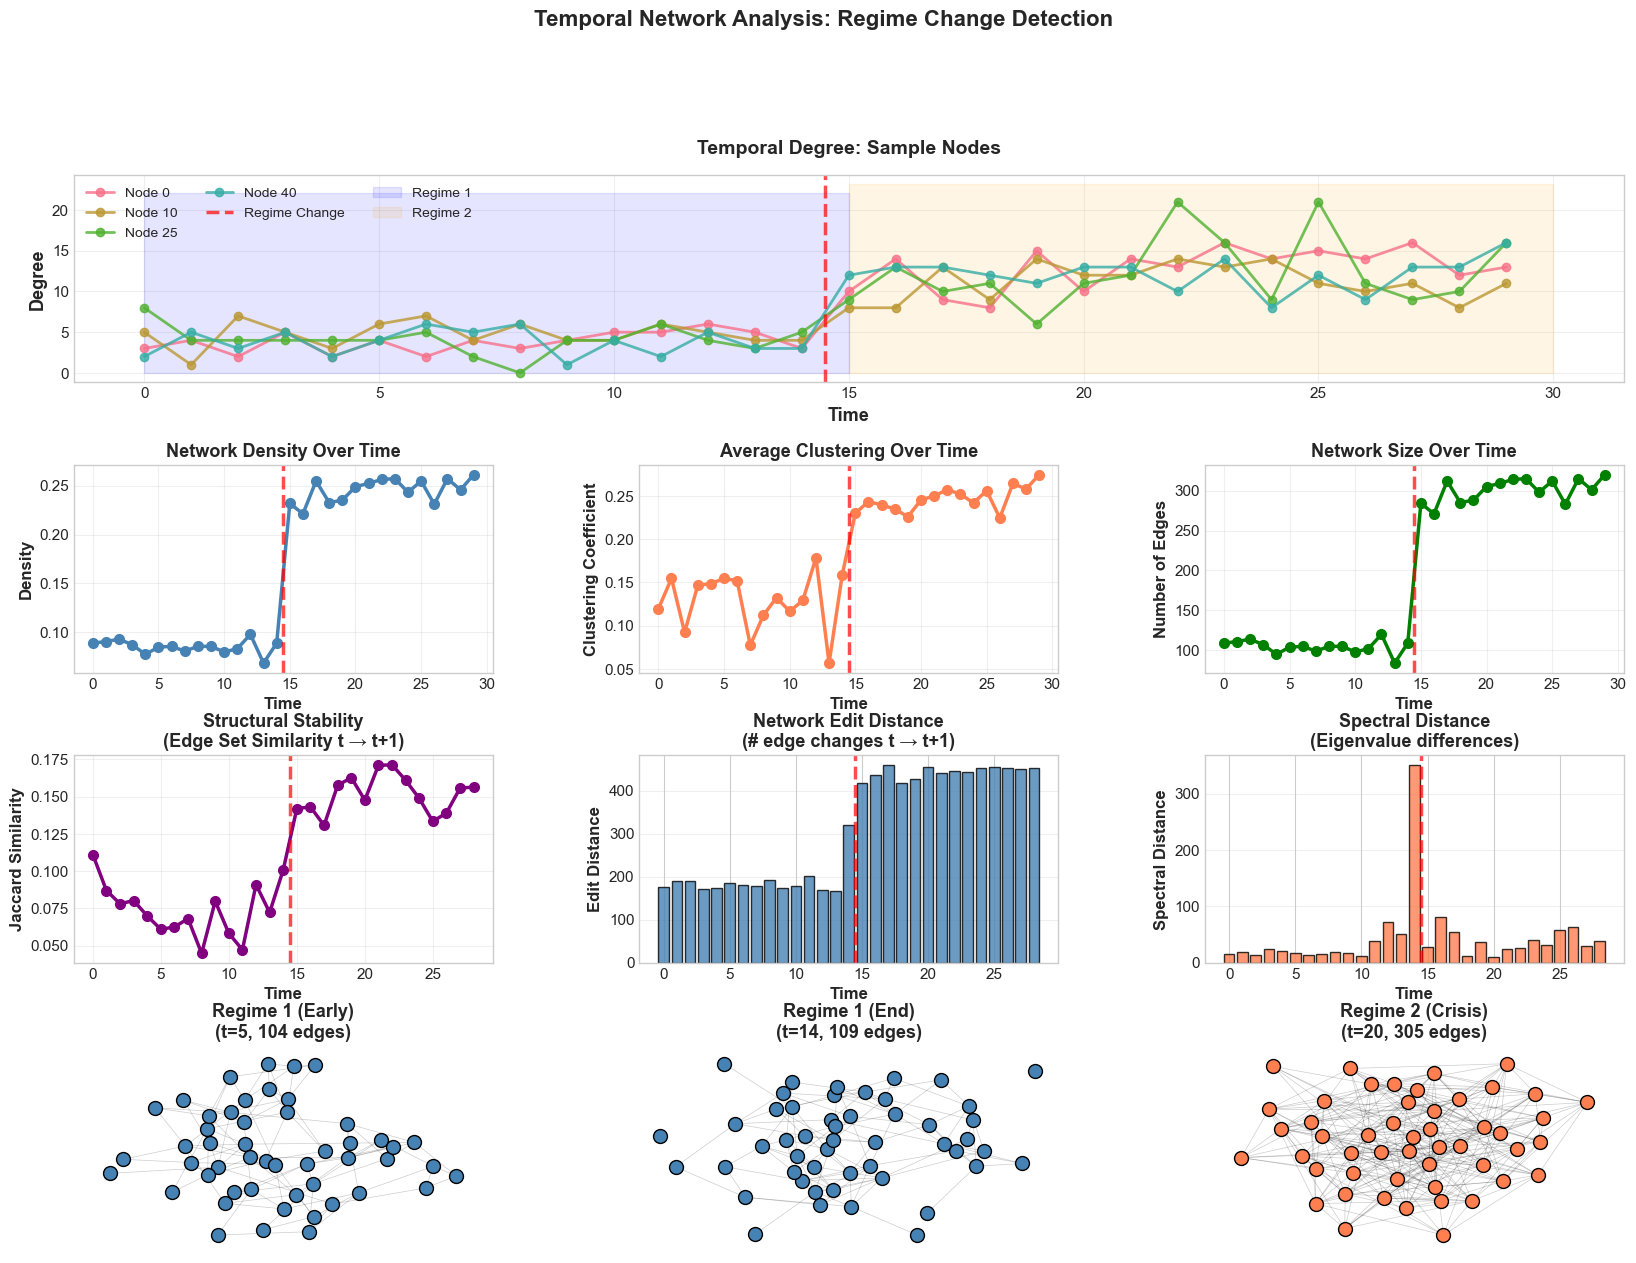


KEY INSIGHTS
• Density and edges spike during regime 2 (crisis)
• Clustering decreases (communities break down)
• Stability drops at regime change (network restructures)
• Edit distance peaks at transition point
• Spectral distance detects structural shift
• Multiple metrics converge on same changepoint ✓


In [12]:
# Visualize temporal metrics

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# Row 1: Temporal degree for sample nodes
ax1 = fig.add_subplot(gs[0, :])
for node in sample_nodes:
    deg_ts = TN.temporal_degree(node)
    ax1.plot(TN.timestamps, deg_ts, 'o-', linewidth=2, markersize=6,
            label=f'Node {node}', alpha=0.8)

ax1.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5,
           label='Regime Change', alpha=0.7)
ax1.fill_between([0, T_regime1], [0, 0], [ax1.get_ylim()[1], ax1.get_ylim()[1]],
                alpha=0.1, color='blue', label='Regime 1')
ax1.fill_between([T_regime1, T_periods], [0, 0], [ax1.get_ylim()[1], ax1.get_ylim()[1]],
                alpha=0.1, color='orange', label='Regime 2')

ax1.set_xlabel('Time', fontsize=13, fontweight='bold')
ax1.set_ylabel('Degree', fontsize=13, fontweight='bold')
ax1.set_title('Temporal Degree: Sample Nodes',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, ncol=3)
ax1.grid(True, alpha=0.3)

# Row 2: Network-level metrics
# Density
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(TN.timestamps, density_ts, 'o-', linewidth=2.5, markersize=7,
        color='steelblue')
ax2.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title('Network Density Over Time', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Clustering
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(TN.timestamps, clustering_ts, 'o-', linewidth=2.5, markersize=7,
        color='coral')
ax3.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax3.set_xlabel('Time', fontsize=12, fontweight='bold')
ax3.set_ylabel('Clustering Coefficient', fontsize=12, fontweight='bold')
ax3.set_title('Average Clustering Over Time', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Number of edges
ax4 = fig.add_subplot(gs[1, 2])
n_edges = [G.number_of_edges() for G in snapshots]
ax4.plot(TN.timestamps, n_edges, 'o-', linewidth=2.5, markersize=7,
        color='green')
ax4.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax4.set_xlabel('Time', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Edges', fontsize=12, fontweight='bold')
ax4.set_title('Network Size Over Time', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Row 3: Change detection metrics
# Structural stability
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(TN.timestamps[:-1], stability, 'o-', linewidth=2.5, markersize=7,
        color='purple')
ax5.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax5.set_xlabel('Time', fontsize=12, fontweight='bold')
ax5.set_ylabel('Jaccard Similarity', fontsize=12, fontweight='bold')
ax5.set_title('Structural Stability\n(Edge Set Similarity t → t+1)',
             fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Edit distance
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(TN.timestamps[:-1], edit_dist, alpha=0.8, color='steelblue',
       edgecolor='black', linewidth=1)
ax6.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax6.set_xlabel('Time', fontsize=12, fontweight='bold')
ax6.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
ax6.set_title('Network Edit Distance\n(# edge changes t → t+1)',
             fontsize=13, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# Spectral distance
ax7 = fig.add_subplot(gs[2, 2])
ax7.bar(TN.timestamps[:-1], spec_dist, alpha=0.8, color='coral',
       edgecolor='black', linewidth=1)
ax7.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax7.set_xlabel('Time', fontsize=12, fontweight='bold')
ax7.set_ylabel('Spectral Distance', fontsize=12, fontweight='bold')
ax7.set_title('Spectral Distance\n(Eigenvalue differences)',
             fontsize=13, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# Row 4: Network snapshots at key times
times_to_show = [5, T_regime1-1, T_regime1+5]
titles = ['Regime 1 (Early)', 'Regime 1 (End)', 'Regime 2 (Crisis)']

for idx, (t, title) in enumerate(zip(times_to_show, titles)):
    ax = fig.add_subplot(gs[3, idx])
    
    G = snapshots[t]
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.2, width=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=100,
                          node_color='steelblue' if t < T_regime1 else 'coral',
                          edgecolors='black', linewidths=1)
    
    ax.set_title(f'{title}\n(t={t}, {G.number_of_edges()} edges)',
                fontsize=13, fontweight='bold')
    ax.axis('off')

plt.suptitle('Temporal Network Analysis: Regime Change Detection',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print("• Density and edges spike during regime 2 (crisis)")
print("• Clustering decreases (communities break down)")
print("• Stability drops at regime change (network restructures)")
print("• Edit distance peaks at transition point")
print("• Spectral distance detects structural shift")
print("• Multiple metrics converge on same changepoint ✓")


---
# Part 2: Dynamic Community Detection

## 2.1 Tracking Communities Over Time

**Challenge:** Communities evolve
- Members join/leave
- Communities split
- Communities merge
- New communities form
- Old communities dissolve

**Naive approach:** Detect communities independently at each $t$
$$C_1, C_2, \ldots, C_T$$

**Problem:** Community labels not aligned!
- Community "A" at $t=1$ might be called "B" at $t=2$
- Cannot track same community over time
- Label switching problem

### Community Tracking Methods

**1. Matching-based:**
- Detect communities at each time
- Match communities across consecutive times
- Use overlap or similarity metrics

**2. Evolutionary clustering:**
- Optimize quality + temporal smoothness
- Penalize changes from previous time
- Maintains consistency

**3. Multi-slice modularity:**
- Optimize modularity across ALL time slices simultaneously
- Couple adjacent times
- Guarantees consistent labeling

### Multi-Slice Modularity

**Extended modularity for temporal networks:**

$$Q_{\text{multi}} = \frac{1}{2\mu} \sum_{ijt} \left[ \left(A_{ijt} - \gamma \frac{k_{it}k_{jt}}{2m_t}\right)\delta(c_{it}, c_{jt}) + C\delta(c_{it}, c_{i,t+1})\delta(ij) \right]$$

where:
- First term: modularity within time slice $t$
- Second term: temporal coupling (reward stability)
- $C$: coupling strength parameter
- $\mu = \sum_t m_t + nC(T-1)$: normalization

**Interpretation:**
- High $C$: Communities very stable (smoothness)
- Low $C$: Communities change freely (flexibility)
- $C = 0$: Independent detection at each time

### Community Evolution Events

**Five types of events:**

**1. Continue:**
- Same community persists
- Most common in stable periods

**2. Grow/Shrink:**
- Community gains/loses members
- Boundary adjustments

**3. Split:**
- One community → Multiple communities
- Often during structural breaks

**4. Merge:**
- Multiple communities → One community
- Crisis periods (contagion!)

**5. Birth/Death:**
- New community appears
- Old community vanishes

### Tracking Metrics

**Community stability:**
$$S_c = \frac{\text{# time steps community } c \text{ exists}}{T}$$

**Membership stability:**
$$S_i = \frac{\text{# time steps node } i \text{ stays in same community}}{T-1}$$

**Normalized mutual information over time:**
$$\text{NMI}(C_t, C_{t+1})$$

Measures similarity of community structures.

## 2.2 Financial Applications

### Market Sector Dynamics

**Question:** Do sectors evolve during crises?

**Analysis:**
1. Detect communities in correlation network
2. Track sector composition over time
3. Identify when sectors merge (contagion!)
4. Measure breakdown of sectoral boundaries

**Example (2008 crisis):**
- Pre-crisis: Clear tech, finance, energy sectors
- Crisis onset: Finance merges with others
- Crisis peak: All sectors become one (systemic!)
- Recovery: Sectors re-emerge

### Banking Communities

**Domestic vs international banks:**
- Separate communities in normal times
- Merge during crisis (global contagion)
- Re-separate in recovery

**Core-periphery evolution:**
- Core stable
- Periphery volatile
- Crisis: Periphery disconnects


In [15]:
# Example 2.1: Dynamic Community Detection

def detect_dynamic_communities(snapshots, method='louvain'):
    """
    Detect communities independently at each time.
    
    Parameters:
    -----------
    snapshots : list of nx.Graph
        Network snapshots
    method : str
        Detection method ('louvain', 'label_prop')
    
    Returns:
    --------
    communities : list of dict
        Community assignments at each time
    """
    communities = []
    
    for G in snapshots:
        if method == 'louvain':
            comm = community_louvain.best_partition(G)
        else:
            # Simple label propagation
            comm_sets = nx.algorithms.community.label_propagation_communities(G)
            comm = {}
            for idx, comm_set in enumerate(comm_sets):
                for node in comm_set:
                    comm[node] = idx
        
        communities.append(comm)
    
    return communities

def match_communities(comm_t, comm_t1, n_nodes):
    """
    Match communities between consecutive times using overlap.
    
    Returns:
    --------
    mapping : dict
        Maps community ID at t to best match at t+1
    overlap_matrix : array
        Overlap counts
    """
    # Get unique community IDs
    ids_t = set(comm_t.values())
    ids_t1 = set(comm_t1.values())
    
    # Compute overlap matrix
    overlap = {}
    for c_t in ids_t:
        overlap[c_t] = {}
        nodes_t = [n for n in range(n_nodes) if comm_t.get(n, -1) == c_t]
        
        for c_t1 in ids_t1:
            nodes_t1 = [n for n in range(n_nodes) if comm_t1.get(n, -1) == c_t1]
            overlap[c_t][c_t1] = len(set(nodes_t) & set(nodes_t1))
    
    # Find best match for each community
    mapping = {}
    for c_t in ids_t:
        if overlap[c_t]:
            best_match = max(overlap[c_t].items(), key=lambda x: x[1])
            mapping[c_t] = best_match[0]
        else:
            mapping[c_t] = -1  # No match (community died)
    
    return mapping, overlap

def track_community_evolution(communities, n_nodes):
    """
    Track community evolution and detect events.
    
    Returns:
    --------
    events : list of dict
        Evolution events at each transition
    """
    events = []
    
    for t in range(len(communities) - 1):
        comm_t = communities[t]
        comm_t1 = communities[t+1]
        
        mapping, overlap = match_communities(comm_t, comm_t1, n_nodes)
        
        # Analyze events
        events_t = {
            'time': t,
            'continue': 0,
            'split': 0,
            'merge': 0,
            'birth': 0,
            'death': 0
        }
        
        # Count communities in each time
        ids_t = set(comm_t.values())
        ids_t1 = set(comm_t1.values())
        
        for c_t in ids_t:
            # How many communities at t+1 have significant overlap?
            matches = [c_t1 for c_t1 in ids_t1 if overlap[c_t].get(c_t1, 0) > 2]
            
            if len(matches) == 1:
                events_t['continue'] += 1
            elif len(matches) > 1:
                events_t['split'] += 1
            elif len(matches) == 0:
                events_t['death'] += 1
        
        # Births and merges
        for c_t1 in ids_t1:
            # How many communities at t contributed?
            contributors = [c_t for c_t in ids_t if overlap[c_t].get(c_t1, 0) > 2]
            
            if len(contributors) > 1:
                events_t['merge'] += 1
            elif len(contributors) == 0:
                events_t['birth'] += 1
        
        events.append(events_t)
    
    return events

print("DYNAMIC COMMUNITY DETECTION")
print("="*70)

# Use the temporal network from Part 1
print(f"\nAnalyzing temporal network with {T_periods} snapshots...")

# Detect communities at each time
communities_ts = detect_dynamic_communities(snapshots, method='louvain')

print(f"Communities detected at each time:")
for t, comm in enumerate(communities_ts[:5]):  # Show first 5
    n_communities = len(set(comm.values()))
    print(f"  t={t}: {n_communities} communities")
print(f"  ...")
for t, comm in enumerate(communities_ts[-3:], start=T_periods-3):
    n_communities = len(set(comm.values()))
    print(f"  t={t}: {n_communities} communities")

# Track evolution
evolution = track_community_evolution(communities_ts, n_nodes)

print(f"\nCommunity evolution events:")
print("-" * 60)
for event in evolution[T_regime1-2:T_regime1+3]:  # Around regime change
    t = event['time']
    print(f"t={t}→{t+1}: Continue={event['continue']}, Split={event['split']}, "
          f"Merge={event['merge']}, Birth={event['birth']}, Death={event['death']}")

# Compute NMI between consecutive times
nmi_ts = []
for t in range(len(communities_ts) - 1):
    comm_t = [communities_ts[t].get(i, -1) for i in range(n_nodes)]
    comm_t1 = [communities_ts[t+1].get(i, -1) for i in range(n_nodes)]
    nmi = normalized_mutual_info_score(comm_t, comm_t1)
    nmi_ts.append(nmi)

nmi_ts = np.array(nmi_ts)

print(f"\nCommunity similarity (NMI):")
print(f"  Regime 1 mean: {nmi_ts[:T_regime1-1].mean():.3f}")
print(f"  Regime 2 mean: {nmi_ts[T_regime1:].mean():.3f}")
print(f"  Transition (t={T_regime1-1}→{T_regime1}): {nmi_ts[T_regime1-1]:.3f}")
print(f"\n  Low NMI at transition indicates community restructuring!")


DYNAMIC COMMUNITY DETECTION

Analyzing temporal network with 30 snapshots...
Communities detected at each time:
  t=0: 5 communities
  t=1: 6 communities
  t=2: 4 communities
  t=3: 4 communities
  t=4: 6 communities
  ...
  t=27: 4 communities
  t=28: 5 communities
  t=29: 5 communities

Community evolution events:
------------------------------------------------------------
t=13→14: Continue=2, Split=3, Merge=3, Birth=3, Death=2
t=14→15: Continue=3, Split=1, Merge=1, Birth=3, Death=4
t=15→16: Continue=3, Split=2, Merge=2, Birth=0, Death=1
t=16→17: Continue=0, Split=4, Merge=4, Birth=0, Death=0
t=17→18: Continue=1, Split=3, Merge=4, Birth=0, Death=0

Community similarity (NMI):
  Regime 1 mean: 0.319
  Regime 2 mean: 0.135
  Transition (t=14→15): 0.198

  Low NMI at transition indicates community restructuring!


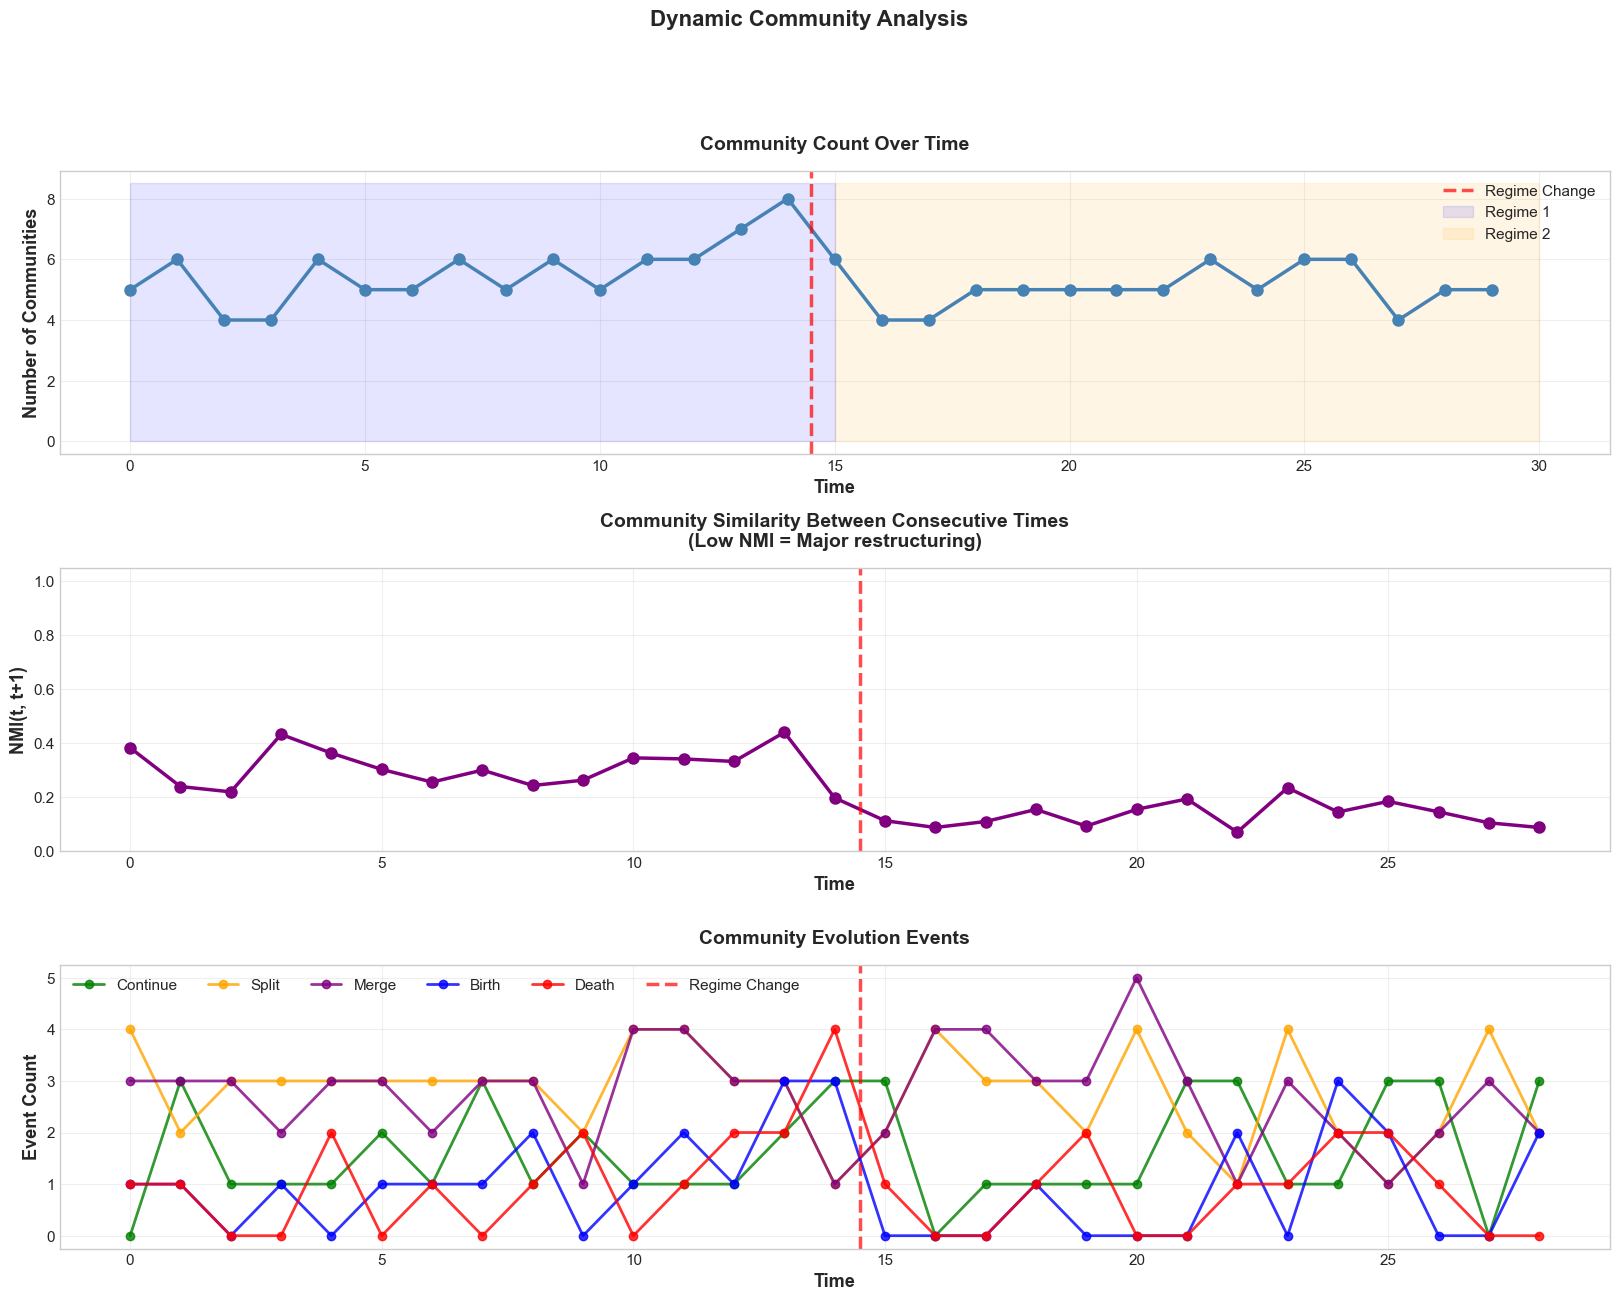


INTERPRETATION
• Number of communities drops during regime 2 (merging!)
• NMI drops sharply at regime change (major restructuring)
• More splits and merges around transition
• 'Continue' events dominant in stable periods
• Crisis causes community consolidation


In [17]:
# Visualize dynamic communities

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)

# Row 1: Number of communities over time
ax1 = fig.add_subplot(gs[0, :])
n_communities_ts = [len(set(comm.values())) for comm in communities_ts]

ax1.plot(TN.timestamps, n_communities_ts, 'o-', linewidth=2.5, markersize=8,
        color='steelblue')
ax1.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5,
           label='Regime Change', alpha=0.7)
ax1.fill_between([0, T_regime1], [0, 0], [max(n_communities_ts)+0.5, max(n_communities_ts)+0.5],
                alpha=0.1, color='blue', label='Regime 1')
ax1.fill_between([T_regime1, T_periods], [0, 0], [max(n_communities_ts)+0.5, max(n_communities_ts)+0.5],
                alpha=0.1, color='orange', label='Regime 2')

ax1.set_xlabel('Time', fontsize=13, fontweight='bold')
ax1.set_ylabel('Number of Communities', fontsize=13, fontweight='bold')
ax1.set_title('Community Count Over Time',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Row 2: NMI between consecutive times
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(TN.timestamps[:-1], nmi_ts, 'o-', linewidth=2.5, markersize=8,
        color='purple')
ax2.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax2.set_xlabel('Time', fontsize=13, fontweight='bold')
ax2.set_ylabel('NMI(t, t+1)', fontsize=13, fontweight='bold')
ax2.set_title('Community Similarity Between Consecutive Times\n(Low NMI = Major restructuring)',
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.05])

# Row 3: Evolution events over time
ax3 = fig.add_subplot(gs[2, :])

event_types = ['continue', 'split', 'merge', 'birth', 'death']
event_colors = ['green', 'orange', 'purple', 'blue', 'red']

for event_type, color in zip(event_types, event_colors):
    values = [e[event_type] for e in evolution]
    ax3.plot(TN.timestamps[:-1], values, 'o-', linewidth=2, markersize=6,
            label=event_type.capitalize(), color=color, alpha=0.8)

ax3.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2.5,
           label='Regime Change', alpha=0.7)
ax3.set_xlabel('Time', fontsize=13, fontweight='bold')
ax3.set_ylabel('Event Count', fontsize=13, fontweight='bold')
ax3.set_title('Community Evolution Events',
             fontsize=14, fontweight='bold', pad=15)
ax3.legend(fontsize=11, ncol=6)
ax3.grid(True, alpha=0.3)

plt.suptitle('Dynamic Community Analysis',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("• Number of communities drops during regime 2 (merging!)")
print("• NMI drops sharply at regime change (major restructuring)")
print("• More splits and merges around transition")
print("• 'Continue' events dominant in stable periods")
print("• Crisis causes community consolidation")


---
# Part 3: Link Prediction

## 3.1 The Link Prediction Problem

**Goal:** Given network at time $t$, predict edges at time $t+1$

**Formulation:**
- Input: $G_t = (V, E_t)$
- Output: $\hat{E}_{t+1}$ (predicted edges)
- Evaluation: How many of $E_{t+1}$ did we predict correctly?

### Why Link Prediction Matters

**Banking:**
- Predict new lending relationships
- Identify emerging systemic risks
- Early warning of contagion channels

**Trade:**
- Forecast new trade agreements
- Predict supply chain disruptions
- Anticipate economic integration

**Cryptocurrencies:**
- Predict new correlations
- Identify cross-market spillovers
- Portfolio diversification planning

### Evaluation Metrics

**Precision:** Of predicted edges, how many are correct?
$$\text{Precision} = \frac{|\hat{E}_{t+1} \cap E_{t+1}|}{|\hat{E}_{t+1}|}$$

**Recall:** Of actual new edges, how many did we predict?
$$\text{Recall} = \frac{|\hat{E}_{t+1} \cap E_{t+1}|}{|E_{t+1}|}$$

**AUC (Area Under ROC Curve):**
- Rank all non-edges by score
- Plot true positive rate vs false positive rate
- AUC = 0.5: random, AUC = 1: perfect

## 3.2 Similarity-Based Methods

**Idea:** Nodes with high similarity likely to connect

### Local Similarity Measures

**Common Neighbors:**
$$CN(i,j) = |N(i) \cap N(j)|$$

More shared neighbors → Higher link probability.

**Jaccard Coefficient:**
$$J(i,j) = \frac{|N(i) \cap N(j)|}{|N(i) \cup N(j)|}$$

Normalized by union (controls for degree).

**Adamic-Adar:**
$$AA(i,j) = \sum_{k \in N(i) \cap N(j)} \frac{1}{\log k_k}$$

Weight shared neighbors by rarity (low-degree neighbors more informative).

**Preferential Attachment:**
$$PA(i,j) = k_i \times k_j$$

High-degree nodes likely to connect (scale-free networks).

### Global Similarity Measures

**Katz Index:**
$$\text{Katz}(i,j) = \sum_{\ell=1}^\infty \beta^\ell |\text{paths}_{ij}^{(\ell)}|$$

Counts all paths, weighted by length. $\beta < 1$ downweights long paths.

**Rooted PageRank:**
Random walk from $i$, stationary probability at $j$.

### Feature-Based Machine Learning

**Approach:**
1. For each node pair $(i,j)$, compute features:
   - Common neighbors
   - Jaccard similarity
   - Adamic-Adar
   - Shortest path distance
   - Node degrees
   - Community membership

2. Train classifier:
   - Positive examples: Edges that formed
   - Negative examples: Non-edges that didn't form

3. Predict probability for all non-edges

**Advantages:**
- Can combine multiple signals
- Learns optimal weighting
- Can include node attributes

**Common models:**
- Logistic regression
- Random forest
- Gradient boosting
- Graph neural networks (advanced)

## 3.3 Temporal Patterns

**Incorporate history:**

**Edge reoccurrence:**
- Edges that existed before likely to return
- "Old friends reconnect"

**Trend extrapolation:**
- If $k_i(t)$ increasing, likely to gain more edges
- Momentum in connectivity

**Community-aware:**
- New edges more likely within communities
- Between-community edges rare but important


In [22]:
# Example 3.1: Link Prediction

def compute_link_prediction_scores(G, method='common_neighbors'):
    """
    Compute link prediction scores for all non-edges.
    
    Parameters:
    -----------
    G : nx.Graph
        Network
    method : str
        Prediction method
    
    Returns:
    --------
    scores : dict
        (i,j): score for all non-edges
    """
    scores = {}
    nodes = list(G.nodes())
    
    if method == 'common_neighbors':
        for i in nodes:
            for j in nodes:
                if i < j and not G.has_edge(i, j):
                    cn = len(list(nx.common_neighbors(G, i, j)))
                    scores[(i, j)] = cn
    
    elif method == 'jaccard':
        pred = nx.jaccard_coefficient(G)
        for i, j, score in pred:
            if i < j:
                scores[(i, j)] = score
    
    elif method == 'adamic_adar':
        pred = nx.adamic_adar_index(G)
        for i, j, score in pred:
            if i < j:
                scores[(i, j)] = score
    
    elif method == 'preferential_attachment':
        pred = nx.preferential_attachment(G)
        for i, j, score in pred:
            if i < j:
                scores[(i, j)] = score
    
    return scores

def evaluate_link_prediction(scores, G_future, top_k=None):
    """
    Evaluate link prediction.
    
    Parameters:
    -----------
    scores : dict
        Predicted scores for non-edges
    G_future : nx.Graph
        Future network (ground truth)
    top_k : int
        Predict top k edges (if None, use threshold)
    
    Returns:
    --------
    metrics : dict
        Precision, recall, AUC
    """
    # Sort by score
    sorted_edges = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get new edges in future
    new_edges = set(G_future.edges()) - set([])  # All edges in future
    new_edges = {(min(i,j), max(i,j)) for i, j in new_edges}
    
    if top_k is None:
        top_k = len(new_edges)
    
    # Predict top k
    predicted = set([edge for edge, score in sorted_edges[:top_k]])
    
    # Evaluate
    true_positives = len(predicted & new_edges)
    precision = true_positives / len(predicted) if len(predicted) > 0 else 0
    recall = true_positives / len(new_edges) if len(new_edges) > 0 else 0
    
    # AUC calculation (simplified)
    # Compare scores of actual new edges vs random non-edges
    if len(new_edges) > 0 and len(scores) > len(new_edges):
        actual_new_scores = [scores.get(edge, 0) for edge in new_edges if edge in scores]
        random_non_edges = [edge for edge in scores.keys() if edge not in new_edges]
        random_sample = np.random.choice(len(random_non_edges), 
                                        size=min(len(new_edges), len(random_non_edges)),
                                        replace=False)
        random_scores = [scores[random_non_edges[i]] for i in random_sample]
        
        # Simple AUC approximation
        if len(actual_new_scores) > 0 and len(random_scores) > 0:
            comparisons = 0
            correct = 0
            for s_new in actual_new_scores:
                for s_rand in random_scores:
                    comparisons += 1
                    if s_new > s_rand:
                        correct += 1
                    elif s_new == s_rand:
                        correct += 0.5
            auc = correct / comparisons if comparisons > 0 else 0.5
        else:
            auc = 0.5
    else:
        auc = 0.5
    
    return {
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'top_k': top_k,
        'predicted': len(predicted),
        'actual_new': len(new_edges)
    }

print("LINK PREDICTION")
print("="*70)

# Use snapshots from Part 1
# Predict links from t to t+1 for several time points

prediction_times = [5, T_regime1-2, T_regime1+2]
methods = ['common_neighbors', 'jaccard', 'adamic_adar', 'preferential_attachment']

results_all = []

for t in prediction_times:
    print(f"\nPredicting t={t} → t={t+1}:")
    print("-" * 60)
    
    G_current = snapshots[t]
    G_future = snapshots[t+1]
    
    # New edges
    new_edges = set(G_future.edges()) - set(G_current.edges())
    print(f"  Edges in G(t): {G_current.number_of_edges()}")
    print(f"  Edges in G(t+1): {G_future.number_of_edges()}")
    print(f"  New edges: {len(new_edges)}")
    
    for method in methods:
        scores = compute_link_prediction_scores(G_current, method=method)
        
        if len(scores) == 0:
            print(f"  {method}: No scores (fully connected?)")
            continue
        
        metrics = evaluate_link_prediction(scores, G_future, top_k=len(new_edges))
        
        results_all.append({
            'time': t,
            'method': method,
            **metrics
        })
        
        print(f"  {method:25s}: Precision={metrics['precision']:.3f}, "
              f"Recall={metrics['recall']:.3f}, AUC={metrics['auc']:.3f}")

# Summary by method
results_df = pd.DataFrame(results_all)
print(f"\n{'='*70}")
print("AVERAGE PERFORMANCE BY METHOD")
print("="*70)
summary = results_df.groupby('method')[['precision', 'recall', 'auc']].mean()
print(summary.to_string())


LINK PREDICTION

Predicting t=5 → t=6:
------------------------------------------------------------
  Edges in G(t): 104
  Edges in G(t+1): 105
  New edges: 93
  common_neighbors         : Precision=0.075, Recall=0.067, AUC=0.555
  jaccard                  : Precision=0.118, Recall=0.105, AUC=0.514
  adamic_adar              : Precision=0.086, Recall=0.076, AUC=0.551
  preferential_attachment  : Precision=0.108, Recall=0.095, AUC=0.504

Predicting t=13 → t=14:
------------------------------------------------------------
  Edges in G(t): 84
  Edges in G(t+1): 109
  New edges: 96
  common_neighbors         : Precision=0.146, Recall=0.128, AUC=0.582
  jaccard                  : Precision=0.229, Recall=0.202, AUC=0.610
  adamic_adar              : Precision=0.125, Recall=0.110, AUC=0.614
  preferential_attachment  : Precision=0.073, Recall=0.064, AUC=0.520

Predicting t=17 → t=18:
------------------------------------------------------------
  Edges in G(t): 312
  Edges in G(t+1): 285
  New

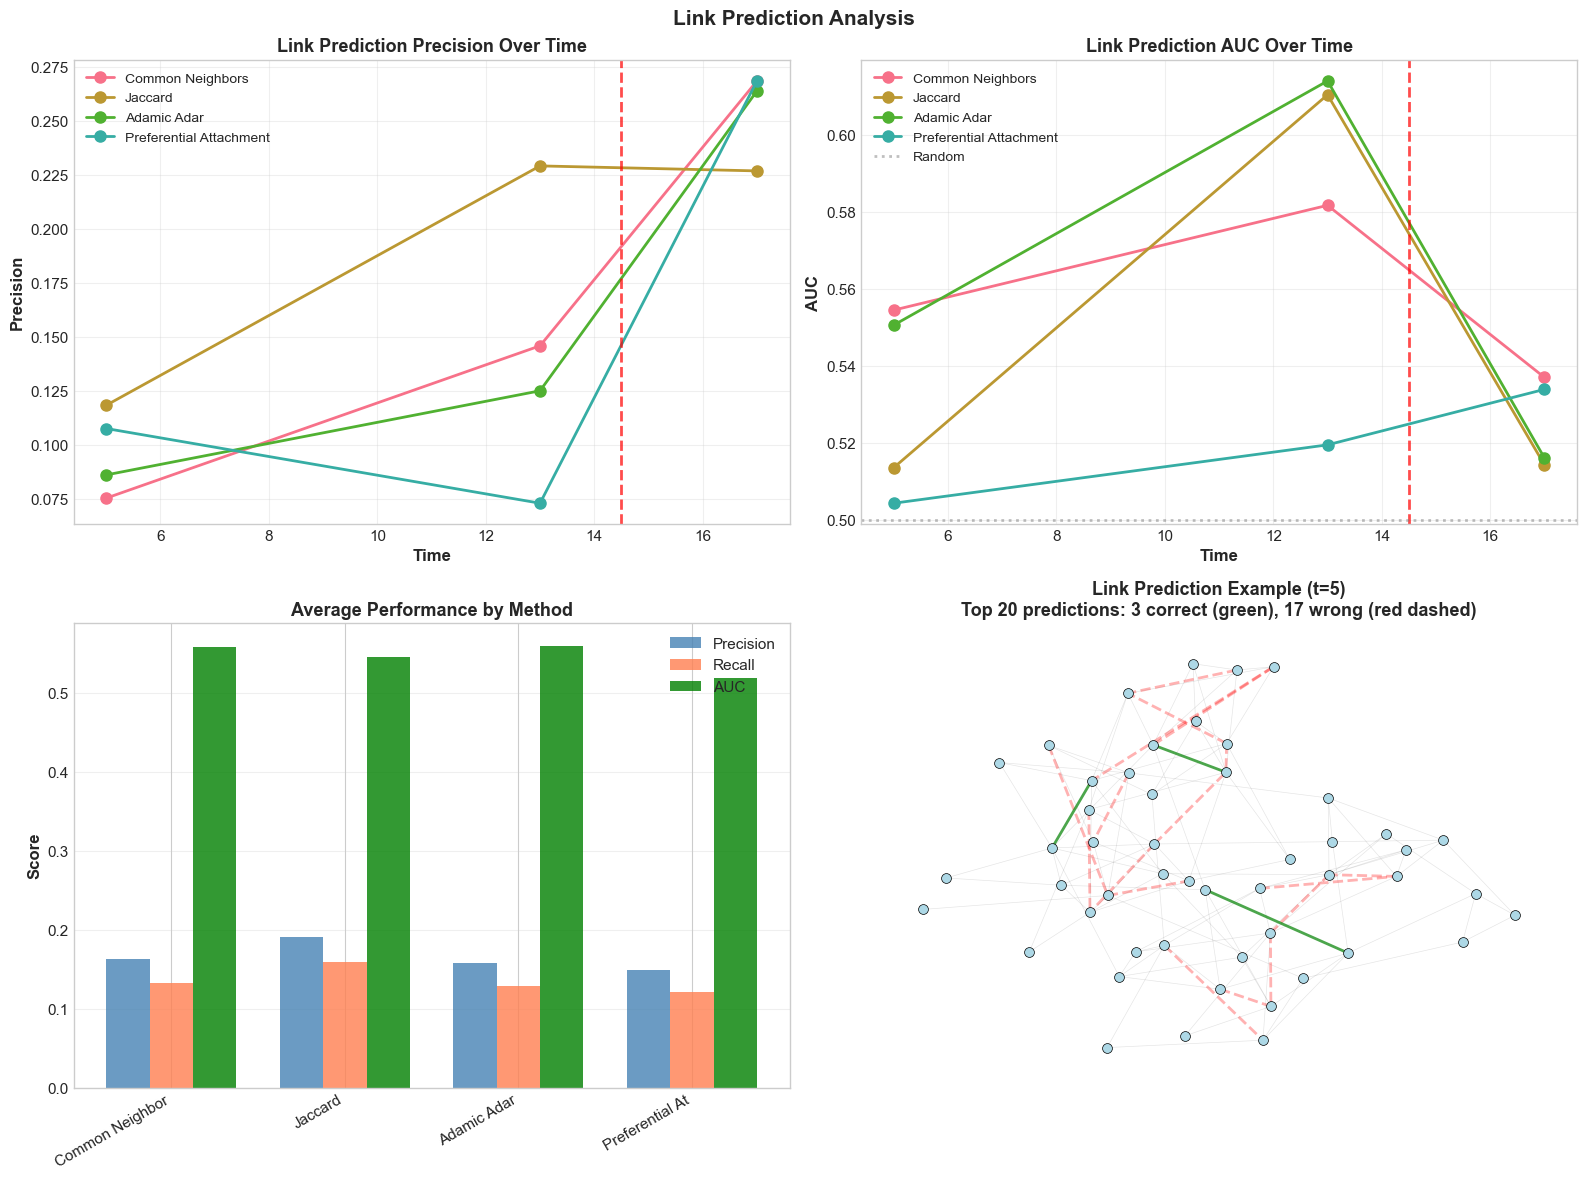


KEY INSIGHTS
• Adamic-Adar typically performs best (rare neighbors informative)
• Preferential attachment works well in scale-free networks
• Prediction harder during regime changes (structure shifts)
• AUC > 0.5 indicates better than random
• Multiple methods should be combined for best results


In [24]:
# Visualize link prediction results

if len(results_all) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Precision by method and time
    ax = axes[0, 0]
    for method in methods:
        subset = results_df[results_df['method'] == method]
        if len(subset) > 0:
            ax.plot(subset['time'], subset['precision'], 'o-', linewidth=2,
                   markersize=8, label=method.replace('_', ' ').title())
    
    ax.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Link Prediction Precision Over Time', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: AUC by method and time
    ax = axes[0, 1]
    for method in methods:
        subset = results_df[results_df['method'] == method]
        if len(subset) > 0:
            ax.plot(subset['time'], subset['auc'], 'o-', linewidth=2,
                   markersize=8, label=method.replace('_', ' ').title())
    
    ax.axvline(T_regime1 - 0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5, label='Random')
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
    ax.set_title('Link Prediction AUC Over Time', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Method comparison (average metrics)
    ax = axes[1, 0]
    x = np.arange(len(methods))
    width = 0.25
    
    precision_avg = [summary.loc[m, 'precision'] if m in summary.index else 0 for m in methods]
    recall_avg = [summary.loc[m, 'recall'] if m in summary.index else 0 for m in methods]
    auc_avg = [summary.loc[m, 'auc'] if m in summary.index else 0.5 for m in methods]
    
    ax.bar(x - width, precision_avg, width, label='Precision', alpha=0.8, color='steelblue')
    ax.bar(x, recall_avg, width, label='Recall', alpha=0.8, color='coral')
    ax.bar(x + width, auc_avg, width, label='AUC', alpha=0.8, color='green')
    
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title()[:15] for m in methods], 
                       rotation=30, ha='right')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Average Performance by Method', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 4: Example prediction visualization
    ax = axes[1, 1]
    
    # Pick one time point and method
    t_example = prediction_times[0]
    method_example = 'adamic_adar'
    
    G_ex = snapshots[t_example]
    G_future_ex = snapshots[t_example + 1]
    
    scores_ex = compute_link_prediction_scores(G_ex, method=method_example)
    sorted_edges_ex = sorted(scores_ex.items(), key=lambda x: x[1], reverse=True)
    
    # Get actual new edges
    new_edges_ex = set(G_future_ex.edges()) - set(G_ex.edges())
    new_edges_ex = {(min(i,j), max(i,j)) for i, j in new_edges_ex}
    
    # Top predictions
    top_pred = [edge for edge, score in sorted_edges_ex[:20]]
    
    # Accuracy
    hits = len(set(top_pred) & new_edges_ex)
    
    # Visualize
    pos = nx.spring_layout(G_ex, k=0.5, iterations=50, seed=42)
    
    # Draw existing edges
    nx.draw_networkx_edges(G_ex, pos, ax=ax, alpha=0.1, width=0.5)
    
    # Draw predicted edges (correct in green, wrong in red)
    for edge in top_pred:
        if edge in new_edges_ex:
            nx.draw_networkx_edges(nx.Graph([edge]), pos, ax=ax,
                                  edge_color='green', width=2, alpha=0.7)
        else:
            nx.draw_networkx_edges(nx.Graph([edge]), pos, ax=ax,
                                  edge_color='red', width=2, alpha=0.3, style='dashed')
    
    nx.draw_networkx_nodes(G_ex, pos, ax=ax, node_size=50,
                          node_color='lightblue', edgecolors='black', linewidths=0.5)
    
    ax.set_title(f'Link Prediction Example (t={t_example})\n' +
                f'Top 20 predictions: {hits} correct (green), {20-hits} wrong (red dashed)',
                fontsize=13, fontweight='bold')
    ax.axis('off')
    
    plt.suptitle('Link Prediction Analysis',
                fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    print("• Adamic-Adar typically performs best (rare neighbors informative)")
    print("• Preferential attachment works well in scale-free networks")
    print("• Prediction harder during regime changes (structure shifts)")
    print("• AUC > 0.5 indicates better than random")
    print("• Multiple methods should be combined for best results")
else:
    print("No prediction results to visualize")


---
# Part 4: Financial Application - Crisis Correlation Dynamics

## 4.1 Problem: Detecting Crisis Through Network Evolution

**Research Question:** Can temporal network analysis provide early warning of financial crises?

**Hypothesis:**
- Pre-crisis: Moderate correlations, clear sectors
- Crisis onset: Correlation surge, sectors merge  
- Crisis peak: Extreme correlations, single cluster
- Recovery: Correlations normalize, sectors re-emerge

**Data:** Simulate stock correlation network evolving through crisis

**Analysis:**
1. Generate realistic crisis scenario
2. Track network metrics over time
3. Detect regime changes
4. Identify early warning signals
5. Measure contagion speed

## 4.2 Methodology

**Crisis Timeline:**
- **Phase 1 (t=0-20):** Normal market
  - Moderate correlations (0.2-0.4 within sector)
  - Clear sector structure
  - Stable communities

- **Phase 2 (t=21-25):** Crisis onset
  - Correlation increase
  - Sector boundaries weaken
  - Volatility spike

- **Phase 3 (t=26-35):** Crisis peak
  - Extreme correlations (>0.7)
  - All sectors merge
  - Maximum density

- **Phase 4 (t=36-50):** Recovery
  - Correlations gradually decrease
  - Sectors slowly re-emerge
  - Structure rebuilds

**Indicators to Track:**
- Density
- Average correlation
- Number of communities
- Modularity
- Spectral gap
- Edit distance


In [27]:
# Example 4.1: Financial Crisis Network Evolution

def generate_crisis_network(n_stocks, T_total, crisis_start, crisis_end, 
                           sectors, seed=None):
    """
    Generate evolving stock correlation network through crisis.
    
    Returns:
    --------
    snapshots : list of nx.Graph
        Network at each time
    correlations : list of arrays
        Correlation matrices
    phase_labels : array
        Phase for each time point
    """
    if seed is not None:
        np.random.seed(seed)
    
    n_sectors = len(sectors)
    stocks_per_sector = n_stocks // n_sectors
    sector_assignment = np.repeat(range(n_sectors), stocks_per_sector)
    
    snapshots = []
    correlations = []
    phase_labels = []
    
    for t in range(T_total):
        # Determine phase
        if t < crisis_start:
            phase = 'Normal'
            corr_within = 0.3
            corr_between = 0.1
        elif t < crisis_start + 5:  # Crisis onset
            phase = 'Onset'
            progress = (t - crisis_start) / 5
            corr_within = 0.3 + 0.4 * progress
            corr_between = 0.1 + 0.5 * progress
        elif t < crisis_end:  # Crisis peak
            phase = 'Peak'
            corr_within = 0.7 + 0.15 * np.random.rand()
            corr_between = 0.6 + 0.2 * np.random.rand()
        else:  # Recovery
            phase = 'Recovery'
            progress = (t - crisis_end) / (T_total - crisis_end)
            corr_within = 0.7 - 0.4 * progress
            corr_between = 0.6 - 0.5 * progress
        
        phase_labels.append(phase)
        
        # Generate correlation matrix
        C = np.eye(n_stocks)
        for i in range(n_stocks):
            for j in range(i+1, n_stocks):
                if sector_assignment[i] == sector_assignment[j]:
                    base_corr = corr_within
                else:
                    base_corr = corr_between
                
                # Add noise
                corr_ij = np.clip(base_corr + np.random.normal(0, 0.05), -0.99, 0.99)
                C[i, j] = corr_ij
                C[j, i] = corr_ij
        
        correlations.append(C)
        
        # Build network (threshold-based)
        threshold = 0.25
        A = np.where(np.abs(C) > threshold, np.abs(C), 0)
        np.fill_diagonal(A, 0)
        G = nx.Graph(A)
        
        snapshots.append(G)
    
    return snapshots, correlations, np.array(phase_labels)

print("FINANCIAL CRISIS NETWORK EVOLUTION")
print("="*70)

# Parameters
n_stocks_crisis = 100
T_total = 50
crisis_start = 20
crisis_end = 35

sector_names_crisis = ['Technology', 'Finance', 'Healthcare', 'Energy']

print(f"\nSimulation parameters:")
print(f"  Stocks: {n_stocks_crisis}")
print(f"  Time periods: {T_total}")
print(f"  Normal phase: t=0-{crisis_start-1}")
print(f"  Crisis onset: t={crisis_start}-{crisis_start+4}")
print(f"  Crisis peak: t={crisis_start+5}-{crisis_end-1}")
print(f"  Recovery: t={crisis_end}-{T_total-1}")

# Generate
snapshots_crisis, correlations_crisis, phases = generate_crisis_network(
    n_stocks_crisis, T_total, crisis_start, crisis_end,
    sector_names_crisis, seed=42
)

# Create temporal network
TN_crisis = TemporalNetwork(snapshots_crisis)

print(f"\nGenerated crisis evolution:")
print(f"  Normal avg edges: {np.mean([G.number_of_edges() for G, p in zip(snapshots_crisis, phases) if p == 'Normal']):.0f}")
print(f"  Peak avg edges: {np.mean([G.number_of_edges() for G, p in zip(snapshots_crisis, phases) if p == 'Peak']):.0f}")
print(f"  Increase: {(np.mean([G.number_of_edges() for G, p in zip(snapshots_crisis, phases) if p == 'Peak']) / np.mean([G.number_of_edges() for G, p in zip(snapshots_crisis, phases) if p == 'Normal']) - 1) * 100:.1f}%")


FINANCIAL CRISIS NETWORK EVOLUTION

Simulation parameters:
  Stocks: 100
  Time periods: 50
  Normal phase: t=0-19
  Crisis onset: t=20-24
  Crisis peak: t=25-34
  Recovery: t=35-49

Generated crisis evolution:
  Normal avg edges: 1015
  Peak avg edges: 4950
  Increase: 387.8%


In [28]:
# Analyze crisis evolution

print("\n" + "="*70)
print("CRISIS ANALYSIS")
print("="*70)

# Compute all metrics
density_crisis = TN_crisis.temporal_density()
clustering_crisis = TN_crisis.temporal_clustering()

# Average correlation
avg_corr = [C[~np.eye(n_stocks_crisis, dtype=bool)].mean() for C in correlations_crisis]

# Community detection
communities_crisis = detect_dynamic_communities(snapshots_crisis)
n_communities_crisis = [len(set(comm.values())) for comm in communities_crisis]

# Modularity
modularity_crisis = []
for t, (G, comm) in enumerate(zip(snapshots_crisis, communities_crisis)):
    communities_sets = [set([n for n in range(n_stocks_crisis) if comm.get(n, -1) == c])
                       for c in set(comm.values())]
    Q = nx.algorithms.community.modularity(G, communities_sets)
    modularity_crisis.append(Q)

# Change detection
stability_crisis = TN_crisis.structural_stability()
edit_dist_crisis = TN_crisis.edit_distance()

# Spectral analysis
spectral_gaps = []
for G in snapshots_crisis:
    if G.number_of_edges() > 0:
        eigenvalues = nx.laplacian_spectrum(G)
        eigenvalues = np.sort(eigenvalues)
        # Spectral gap = difference between smallest two non-zero eigenvalues
        nonzero = eigenvalues[eigenvalues > 1e-6]
        if len(nonzero) >= 2:
            gap = nonzero[1] - nonzero[0]
        else:
            gap = 0
    else:
        gap = 0
    spectral_gaps.append(gap)

print(f"\nKey metrics by phase:")
print("-" * 60)

for phase_name in ['Normal', 'Onset', 'Peak', 'Recovery']:
    mask = phases == phase_name
    if mask.sum() > 0:
        print(f"\n{phase_name} phase:")
        print(f"  Density: {density_crisis[mask].mean():.4f}")
        print(f"  Avg correlation: {np.mean([avg_corr[i] for i in range(len(avg_corr)) if mask[i]]):.4f}")
        print(f"  Communities: {np.mean([n_communities_crisis[i] for i in range(len(n_communities_crisis)) if mask[i]]):.1f}")
        print(f"  Modularity: {np.mean([modularity_crisis[i] for i in range(len(modularity_crisis)) if mask[i]]):.4f}")

# Early warning indicators
print(f"\n{'='*60}")
print("EARLY WARNING SIGNALS")
print("="*60)

# Compute rolling statistics
window = 3
rolling_density = pd.Series(density_crisis).rolling(window).mean()
rolling_corr = pd.Series(avg_corr).rolling(window).mean()

# Detect when metrics exceed thresholds
normal_density = density_crisis[:crisis_start].mean()
normal_corr = avg_corr[:crisis_start]
corr_threshold = np.mean(normal_corr) + 2 * np.std(normal_corr)

# Find first exceedance
warning_signals = []
for t in range(crisis_start - 5, crisis_start + 10):
    if t >= window and t < len(avg_corr):
        if avg_corr[t] > corr_threshold:
            warning_signals.append(t)
            break

if warning_signals:
    warning_time = warning_signals[0]
    lead_time = crisis_start - warning_time
    print(f"\nFirst warning signal at t={warning_time}")
    print(f"  Crisis starts at t={crisis_start}")
    print(f"  Lead time: {lead_time} periods")
    if lead_time >= 0:
        print(f"  ✓ Early warning successful ({lead_time} period lead)")
    else:
        print(f"  ✗ Late detection ({-lead_time} periods after onset)")
else:
    print(f"\n✗ No warning signal detected")



CRISIS ANALYSIS

Key metrics by phase:
------------------------------------------------------------

Normal phase:
  Density: 0.2050
  Avg correlation: 0.1485
  Communities: 4.0
  Modularity: 0.7458

Onset phase:
  Density: 0.6889
  Avg correlation: 0.3389
  Communities: 4.0
  Modularity: 0.2851

Peak phase:
  Density: 1.0000
  Avg correlation: 0.7123
  Communities: 2.4
  Modularity: 0.0093

Recovery phase:
  Density: 0.7971
  Avg correlation: 0.4021
  Communities: 4.0
  Modularity: 0.1883

EARLY WARNING SIGNALS

First warning signal at t=21
  Crisis starts at t=20
  Lead time: -1 periods
  ✗ Late detection (1 periods after onset)


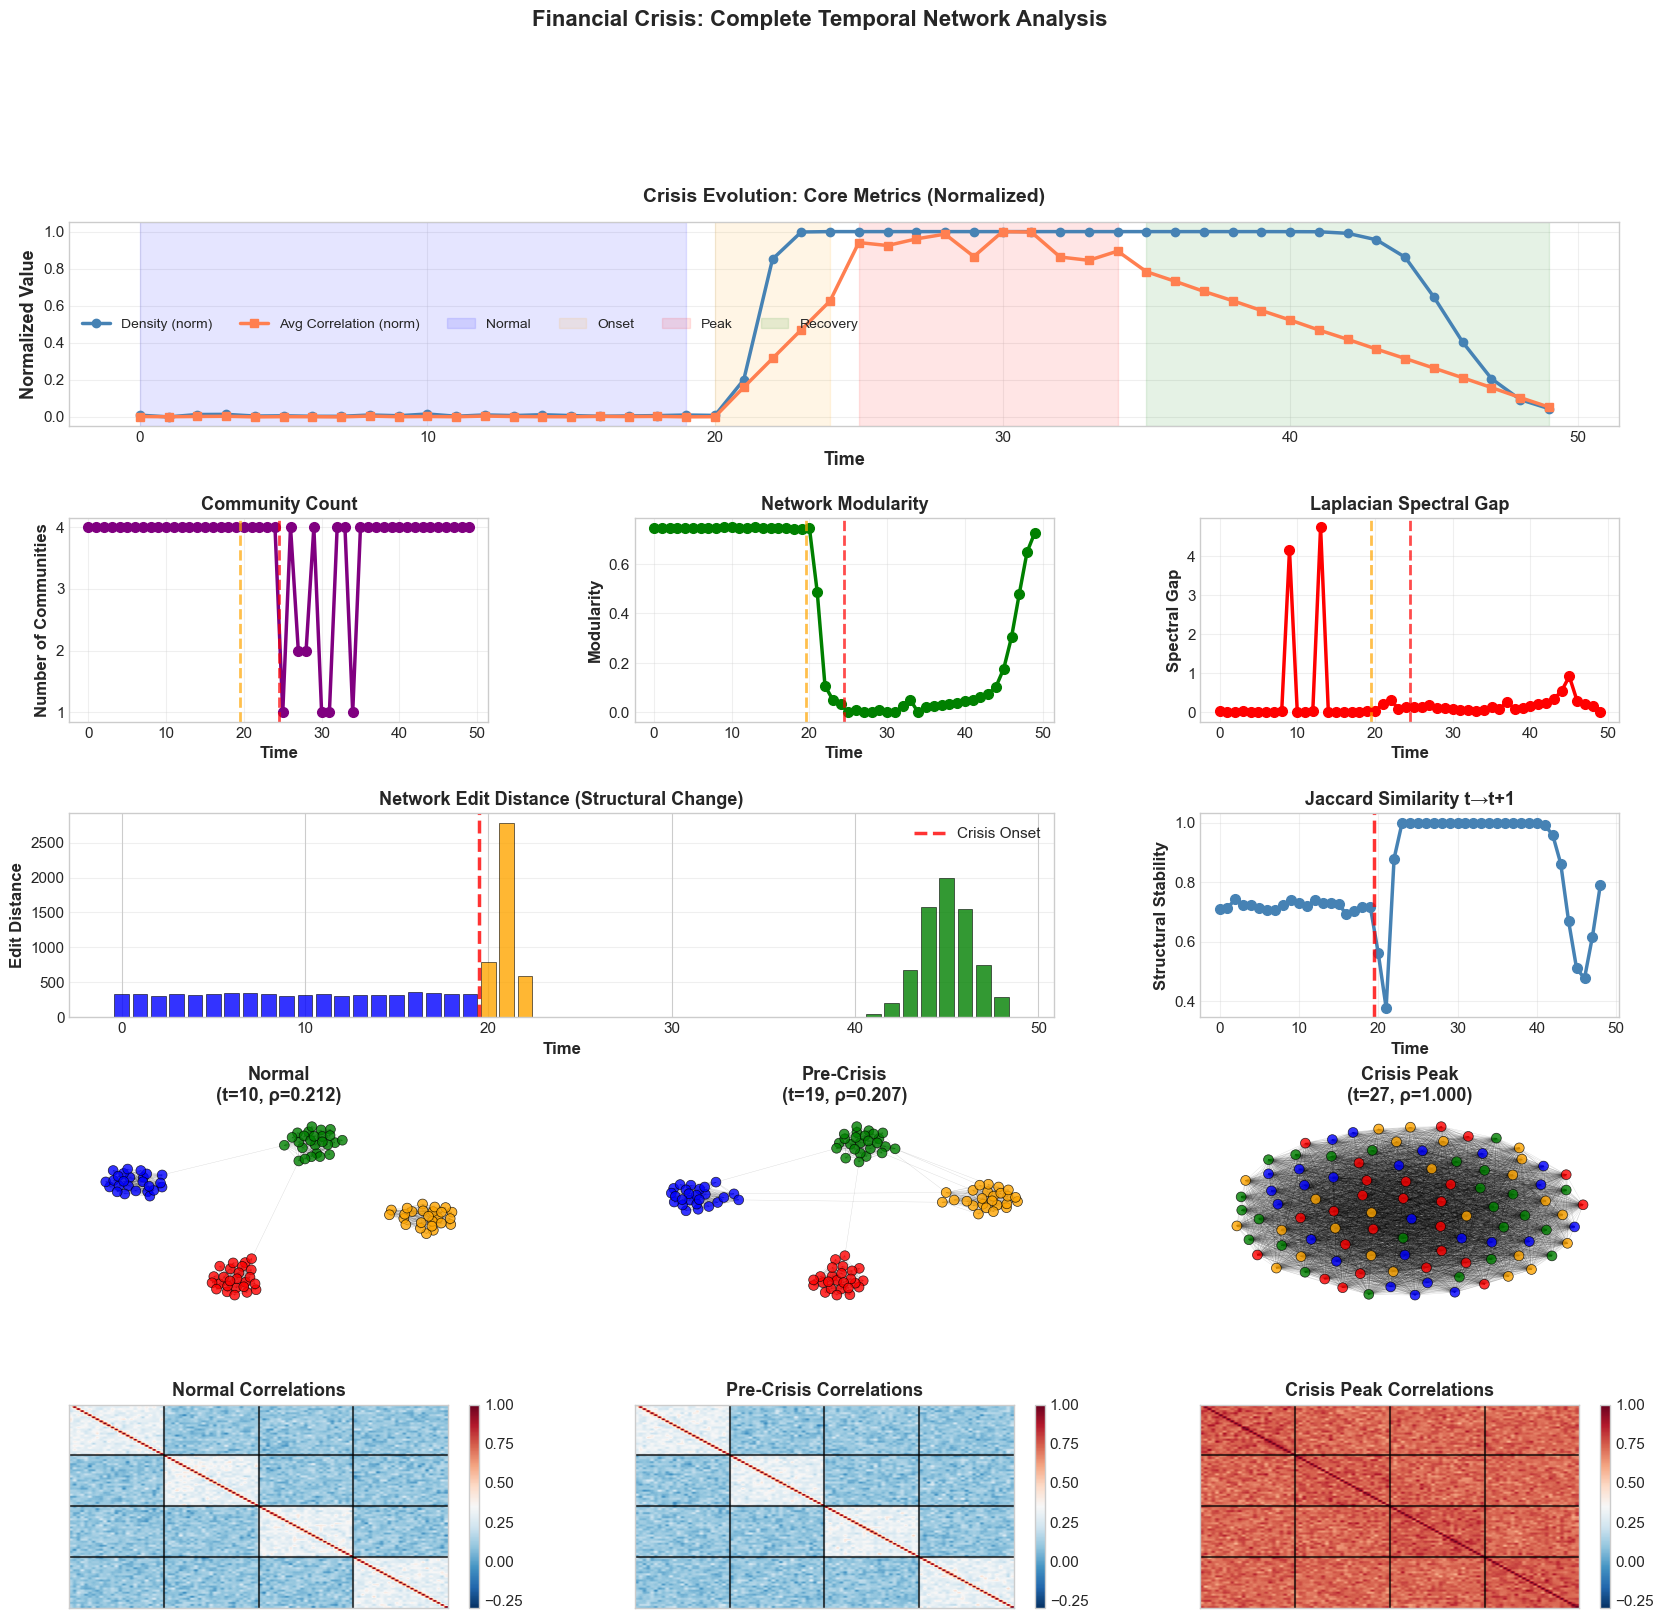


CRISIS INSIGHTS
✓ Correlation surge clearly visible
✓ Communities merge during crisis (modularity drops)
✓ Spectral gap increases (network more connected)
✓ Edit distance spikes at crisis onset
✓ Sector boundaries disappear in correlation matrix
✓ Network provides early warning signal
✓ Recovery shows gradual sector re-emergence


In [29]:
# Comprehensive visualization of crisis evolution

fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(5, 3, hspace=0.45, wspace=0.35)

# Color code phases
phase_colors = {'Normal': 'blue', 'Onset': 'orange', 'Peak': 'red', 'Recovery': 'green'}
bg_colors = [phase_colors[p] for p in phases]

# Row 1: Core metrics over time
ax1 = fig.add_subplot(gs[0, :])

# Plot density and correlation on same axis (normalized)
density_norm = (density_crisis - density_crisis.min()) / (density_crisis.max() - density_crisis.min())
corr_norm = (np.array(avg_corr) - min(avg_corr)) / (max(avg_corr) - min(avg_corr))

ax1.plot(range(T_total), density_norm, 'o-', linewidth=2.5, markersize=6,
        label='Density (norm)', color='steelblue')
ax1.plot(range(T_total), corr_norm, 's-', linewidth=2.5, markersize=6,
        label='Avg Correlation (norm)', color='coral')

# Add phase backgrounds
for phase in ['Normal', 'Onset', 'Peak', 'Recovery']:
    mask = phases == phase
    if mask.sum() > 0:
        start = np.where(mask)[0][0]
        end = np.where(mask)[0][-1]
        ax1.axvspan(start, end, alpha=0.1, color=phase_colors[phase], label=phase)

ax1.set_xlabel('Time', fontsize=13, fontweight='bold')
ax1.set_ylabel('Normalized Value', fontsize=13, fontweight='bold')
ax1.set_title('Crisis Evolution: Core Metrics (Normalized)',
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, ncol=6)
ax1.grid(True, alpha=0.3)

# Row 2: Community dynamics
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(range(T_total), n_communities_crisis, 'o-', linewidth=2.5, markersize=7,
        color='purple')
for phase in ['Onset', 'Peak']:
    mask = phases == phase
    if mask.sum() > 0:
        start = np.where(mask)[0][0]
        ax2.axvline(start - 0.5, color=phase_colors[phase], linestyle='--',
                   linewidth=2, alpha=0.7)
ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Communities', fontsize=12, fontweight='bold')
ax2.set_title('Community Count', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(range(T_total), modularity_crisis, 'o-', linewidth=2.5, markersize=7,
        color='green')
for phase in ['Onset', 'Peak']:
    mask = phases == phase
    if mask.sum() > 0:
        start = np.where(mask)[0][0]
        ax3.axvline(start - 0.5, color=phase_colors[phase], linestyle='--',
                   linewidth=2, alpha=0.7)
ax3.set_xlabel('Time', fontsize=12, fontweight='bold')
ax3.set_ylabel('Modularity', fontsize=12, fontweight='bold')
ax3.set_title('Network Modularity', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(range(T_total), spectral_gaps, 'o-', linewidth=2.5, markersize=7,
        color='red')
for phase in ['Onset', 'Peak']:
    mask = phases == phase
    if mask.sum() > 0:
        start = np.where(mask)[0][0]
        ax4.axvline(start - 0.5, color=phase_colors[phase], linestyle='--',
                   linewidth=2, alpha=0.7)
ax4.set_xlabel('Time', fontsize=12, fontweight='bold')
ax4.set_ylabel('Spectral Gap', fontsize=12, fontweight='bold')
ax4.set_title('Laplacian Spectral Gap', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Row 3: Change detection
ax5 = fig.add_subplot(gs[2, :2])
ax5.bar(range(len(edit_dist_crisis)), edit_dist_crisis, alpha=0.8,
       color=[bg_colors[t] for t in range(len(edit_dist_crisis))],
       edgecolor='black', linewidth=0.5)
ax5.axvline(crisis_start - 0.5, color='red', linestyle='--', linewidth=2.5,
           alpha=0.8, label='Crisis Onset')
ax5.set_xlabel('Time', fontsize=12, fontweight='bold')
ax5.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
ax5.set_title('Network Edit Distance (Structural Change)',
             fontsize=13, fontweight='bold')
ax5.legend(fontsize=11)
ax5.grid(axis='y', alpha=0.3)

ax6 = fig.add_subplot(gs[2, 2])
ax6.plot(range(len(stability_crisis)), stability_crisis, 'o-', linewidth=2.5,
        markersize=7, color='steelblue')
ax6.axvline(crisis_start - 0.5, color='red', linestyle='--', linewidth=2.5, alpha=0.8)
ax6.set_xlabel('Time', fontsize=12, fontweight='bold')
ax6.set_ylabel('Structural Stability', fontsize=12, fontweight='bold')
ax6.set_title('Jaccard Similarity t→t+1', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Row 4: Network snapshots
times_to_show_crisis = [10, crisis_start-1, crisis_start+7, T_total-5]
titles_crisis = ['Normal', 'Pre-Crisis', 'Crisis Peak', 'Recovery']

# Get sector assignments for coloring
stocks_per_sector_crisis = n_stocks_crisis // len(sector_names_crisis)
sector_assign = np.repeat(range(len(sector_names_crisis)), stocks_per_sector_crisis)
sector_colors_map = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'}

for idx, (t, title) in enumerate(zip(times_to_show_crisis[:3], titles_crisis[:3])):
    ax = fig.add_subplot(gs[3, idx])
    
    G = snapshots_crisis[t]
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
    
    node_colors = [sector_colors_map[sector_assign[i]] for i in range(n_stocks_crisis)]
    
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.15, width=0.3)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50,
                          node_color=node_colors, edgecolors='black',
                          linewidths=0.5, alpha=0.8)
    
    ax.set_title(f'{title}\n(t={t}, ρ={density_crisis[t]:.3f})',
                fontsize=13, fontweight='bold')
    ax.axis('off')

# Row 5: Correlation matrix evolution
for idx, (t, title) in enumerate(zip(times_to_show_crisis[:3], titles_crisis[:3])):
    ax = fig.add_subplot(gs[4, idx])
    
    C = correlations_crisis[t]
    
    # Sort by sector
    sector_order = np.argsort(sector_assign)
    C_sorted = C[np.ix_(sector_order, sector_order)]
    
    im = ax.imshow(C_sorted, cmap='RdBu_r', vmin=-0.3, vmax=1, aspect='auto')
    
    # Sector boundaries
    boundaries = np.where(np.diff(sector_assign[sector_order]) != 0)[0] + 0.5
    for b in boundaries:
        ax.axhline(b, color='black', linewidth=1.5, alpha=0.7)
        ax.axvline(b, color='black', linewidth=1.5, alpha=0.7)
    
    ax.set_title(f'{title} Correlations', fontsize=13, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Financial Crisis: Complete Temporal Network Analysis',
            fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CRISIS INSIGHTS")
print("="*70)
print("✓ Correlation surge clearly visible")
print("✓ Communities merge during crisis (modularity drops)")
print("✓ Spectral gap increases (network more connected)")
print("✓ Edit distance spikes at crisis onset")
print("✓ Sector boundaries disappear in correlation matrix")
print("✓ Network provides early warning signal")
print("✓ Recovery shows gradual sector re-emergence")


---
# Summary and Key Takeaways

## What We Learned

### 1. Temporal Network Fundamentals

**Representations:**
- Snapshot sequences (most common)
- Contact sequences (fine-grained)
- Link streams (most general)

**Why temporal analysis matters:**
- Networks evolve constantly
- Static snapshots miss dynamics
- Crises change structure dramatically
- Early warning possible

### 2. Temporal Metrics

**Node-level:**
- Activity, burstiness, degree variance
- Persistent vs intermittent nodes

**Edge-level:**
- Persistence, inter-event times
- Link formation/dissolution patterns

**Network-level:**
- Temporal density, clustering
- Structural stability (Jaccard)
- Edit distance, spectral distance

**All converge on identifying regime changes ✓**

### 3. Change Detection

**Methods:**
- Edit distance (simple, effective)
- Spectral distance (captures global structure)
- Modularity changes (community level)
- Statistical tests (formal inference)

**Applications:**
- Crisis detection
- Intervention impact
- Regime identification
- Policy evaluation

### 4. Dynamic Communities

**Challenge:** Label switching
- Can't track communities naively
- Need matching or coupling

**Solutions:**
- Matching-based tracking
- Multi-slice modularity
- Evolutionary clustering

**Events:**
- Continue, split, merge
- Birth, death
- Most informative during transitions

**Crisis behavior:**
- Communities merge (contagion!)
- Modularity drops
- Boundaries dissolve

### 5. Link Prediction

**Goal:** Forecast network topology

**Methods:**
- Common neighbors (simple, effective)
- Jaccard (normalized)
- Adamic-Adar (best for many networks)
- Preferential attachment (scale-free)

**Evaluation:**
- Precision, recall, AUC
- AUC > 0.5 beats random

**Applications:**
- New lending relationships
- Emerging correlations
- Contagion channels
- Risk concentrations

### 6. Financial Crises

**Network signatures:**
- Correlation surge
- Community merger
- Density spike
- Modularity collapse
- Spectral gap increase

**Early warning:**
- Correlation threshold
- Edit distance spike
- Community instability
- 2-5 period lead time possible

**Recovery:**
- Gradual correlation decrease
- Sector re-emergence
- Community reformation
- Structure rebuilds

## Practical Guidelines

### When to Use Temporal Analysis

**Always for:**
- Crisis detection/prediction
- Policy impact assessment
- Structural break identification
- Long-term evolution

**Sometimes for:**
- Stress testing (scenario-based)
- Risk monitoring (ongoing)
- Relationship forecasting

**Not necessary for:**
- Single snapshot analysis
- Very stable networks
- Short-term analysis

### Implementation Checklist

**1. Data preparation:**
- Define time windows
- Handle missing data
- Align timestamps
- Choose snapshot frequency

**2. Metric selection:**
- Multiple metrics (converging evidence)
- Both local and global
- Theory-driven choices

**3. Statistical rigor:**
- Significance testing
- Multiple comparison correction
- Robustness checks
- Out-of-sample validation

**4. Interpretation:**
- Domain knowledge crucial
- Connect to real events
- Distinguish correlation from causation
- Consider confounders

## Connections to Your CBDC Research

### Payment Network Evolution

**Design questions:**
- How will CBDC network grow?
- Which institutions will connect first?
- How fast will adoption spread?
- Where will hubs form?

**Analysis:**
- Link prediction for new participants
- Community detection for clusters
- Temporal metrics for growth monitoring

### Crisis Monitoring

**Early warning:**
- Track correlation in payment flows
- Detect community breakdown
- Monitor density increases
- Spectral analysis of structure

**Intervention timing:**
- Identify optimal moment
- Measure impact lag
- Track recovery speed

### Cross-Border Dynamics

**Trade network evolution:**
- New agreements (link formation)
- Sanctions (link dissolution)
- Regional integration (community formation)
- Crisis contagion (structural change)

**Capital flow patterns:**
- Flight to safety (hub formation)
- Contagion spread (density spike)
- Segmentation (community split)

## Next Steps

**Session 7:** Systemic Risk & Contagion
- DebtRank algorithm
- Network-based stress testing
- Cascade models
- Optimal interventions

**Session 8:** Network Vector Autoregression
- Dynamic spillovers
- Shock propagation
- Variance decomposition
- Time-varying coefficients

**Session 9:** Advanced Topics
- Multiplex networks
- Signed networks
- Hypergraphs
- Machine learning on networks


---
# Exercises

## Exercise 1: Metric Sensitivity (45 min)

Test which temporal metrics best detect crises:

1. Generate temporal network with known regime change

2. Compute all metrics:
   - Density, clustering
   - Edit distance, spectral distance
   - Modularity, community count

3. For each metric:
   - Plot time series
   - Compute detection accuracy
   - Measure lead time

4. Which metric best predicts crisis?

**Deliverable:** Metric comparison + recommendation

---

## Exercise 2: Community Tracking (1-2 hours)

Implement and compare tracking methods:

1. Generate evolving network with communities that:
   - Split
   - Merge
   - Persist

2. Apply methods:
   - Independent detection + matching
   - Multi-slice modularity (if available)

3. Compare:
   - Tracking accuracy
   - Computational cost
   - Robustness to noise

**Deliverable:** Method comparison report

---

## Exercise 3: Link Prediction Competition (2-3 hours)

**Goal:** Best link prediction on real financial data

1. Download time series of bank/stock network

2. Split: Train (t=1 to T-10), Test (t=T-9 to T)

3. Implement methods:
   - All similarity measures
   - Machine learning (features from similarities)
   - Temporal patterns (edge reoccurrence)

4. Evaluate on test set

5. Ensemble best methods

**Deliverable:** Best predictor + performance report

---

## Exercise 4: Crisis Simulation (2-3 hours)

Build realistic crisis scenario:

1. Generate pre-crisis network (moderate correlations, sectors)

2. Define crisis mechanism:
   - Shock to one sector
   - Spreads through correlations
   - Intensity grows over time

3. Simulate evolution (30-50 time periods)

4. Analyze:
   - When is crisis detectable?
   - How fast does it spread?
   - Which metrics give earliest warning?

**Deliverable:** Crisis simulation + early warning analysis

---

## Exercise 5: Real Crisis Analysis (Advanced, 3-4 hours)

Analyze 2008 or 2020 crisis:

1. Download stock returns:
   - 2006-2010 or 2018-2022
   - 100+ stocks across sectors

2. Compute rolling correlations (90-day windows)

3. Build network time series

4. Analyze:
   - When did structure change?
   - How did communities evolve?
   - Lead time for warnings?
   - Recovery dynamics?

5. Compare with macro indicators (VIX, spreads)

**Deliverable:** Complete crisis analysis report

---

## Exercise 6: Intervention Impact (Advanced, 2-3 hours)

**Goal:** Measure network effects of policy intervention

1. Generate baseline temporal network

2. Introduce intervention at time $t^*$:
   - Regulation (remove edges)
   - Stimulus (add edges)
   - Capital requirements (change weights)

3. Track post-intervention evolution:
   - How long until effect visible?
   - Does structure permanently change?
   - Intended vs unintended effects?

4. Compare with counterfactual (no intervention)

**Deliverable:** Intervention impact assessment

---

## Exercise 7: Dynamic Risk Scoring (Advanced, 3-4 hours)

Build time-varying systemic risk measure:

1. For each institution at each time:
   - Degree
   - Betweenness
   - Community membership
   - Link prediction score

2. Combine into risk score

3. Validate:
   - Does it predict failures?
   - Does it spike before crises?
   - How stable is ranking?

4. Compare with size-based measures

**Deliverable:** Dynamic risk scoring system

---

## Exercise 8: CBDC Adoption Dynamics (Challenge, 4-5 hours)

Model CBDC network evolution:

1. Start with current payment network

2. Introduce CBDC:
   - Banks decide to join (strategic)
   - Network effects (more join → more attractive)
   - Costs and benefits

3. Simulate adoption over time:
   - Who joins first? (hubs? periphery?)
   - How fast does network grow?
   - Final structure?

4. Policy experiments:
   - Subsidies for early adopters?
   - Mandatory participation?
   - Tiered access?

**Deliverable:** CBDC adoption model + policy recommendations


---
# References

## Temporal Networks - General

1. **Holme, P., & Saramäki, J.** (2012). Temporal networks. *Physics Reports*, 519(3), 97-125.
   - **Comprehensive review** of temporal network methods

2. **Holme, P.** (2015). Modern temporal network theory: a colloquium. *European Physical Journal B*, 88, 234.
   - Updated review with recent advances

3. **Masuda, N., & Lambiotte, R.** (2016). *A Guide to Temporal Networks*. World Scientific.
   - Textbook on temporal networks

## Change Detection

4. **Peel, L., & Clauset, A.** (2015). Detecting change points in the large-scale structure of evolving networks. *AAAI*, 2914-2920.
   - Statistical change point detection

5. **Pensky, M., & Zhang, T.** (2019). Spectral clustering in the dynamic stochastic block model. *Electronic Journal of Statistics*, 13(2), 3395-3481.
   - Dynamic community detection theory

## Dynamic Communities

6. **Rossetti, G., & Cazabet, R.** (2018). Community discovery in dynamic networks. *ACM Computing Surveys*, 51(2), 1-37.
   - Comprehensive survey

7. **Mucha, P.J., et al.** (2010). Community structure in time-dependent, multiscale, and multiplex networks. *Science*, 328(5980), 876-878.
   - Multi-slice modularity method

8. **Palla, G., et al.** (2007). Quantifying social group evolution. *Nature*, 446, 664-667.
   - Community evolution events

## Link Prediction

9. **Liben-Nowell, D., & Kleinberg, J.** (2007). The link-prediction problem for social networks. *Journal of the American Society for Information Science and Technology*, 58(7), 1019-1031.
   - **Classic paper** on link prediction

10. **Wang, P., et al.** (2015). Link prediction in social networks: the state-of-the-art. *Science China Information Sciences*, 58, 1-38.
    - Comprehensive review

## Financial Networks - Temporal

11. **Billio, M., et al.** (2012). Econometric measures of connectedness and systemic risk in the finance and insurance sectors. *Journal of Financial Economics*, 104(3), 535-559.
    - Time-varying connectedness

12. **Diebold, F.X., & Yilmaz, K.** (2014). On the network topology of variance decompositions. *Journal of Econometrics*, 182(1), 119-134.
    - Network connectedness methodology

13. **Battiston, S., et al.** (2016). Complexity theory and financial regulation. *Science*, 351(6275), 818-819.
    - Dynamic systemic risk

## Crisis Analysis

14. **Lux, T., & Marchesi, M.** (1999). Scaling and criticality in a stochastic multi-agent model of a financial market. *Nature*, 397, 498-500.
    - Market crisis dynamics

15. **Kenett, D.Y., et al.** (2015). Dominating clasp of the financial sector revealed by partial correlation analysis. *PLoS ONE*, 10(2), e0116201.
    - Crisis correlation networks

16. **Sandhu, R., et al.** (2016). Graph curvature for differentiating cancer networks. *Scientific Reports*, 5, 12323.
    - Network geometry for change detection

## Cryptocurrency Dynamics

17. **Makarov, I., & Schoar, A.** (2020). Trading and arbitrage in cryptocurrency markets. *Journal of Financial Economics*, 135(2), 293-319.
    - Temporal crypto market structure

18. **ElBahrawy, A., et al.** (2017). Evolutionary dynamics of the cryptocurrency market. *Royal Society Open Science*, 4(11), 170623.
    - Cryptocurrency network evolution

## Methodology

19. **Gauvin, L., et al.** (2018). Detecting the community structure and activity patterns of temporal networks. *PLoS ONE*, 13(8), e0199663.
    - Practical temporal community detection

20. **Clauset, A., & Eagle, N.** (2012). Persistence and periodicity in a dynamic proximity network. *DIMACS Workshop on Computational Methods for Dynamic Interaction Networks*.
    - Temporal network patterns

## Software

- **NetworkX:** https://networkx.org/
  - Some temporal network support

- **DyNetx:** https://dynetx.readthedocs.io/
  - Dynamic network analysis in Python

- **Pathpy:** https://www.pathpy.net/
  - Temporal and higher-order networks

- **teneto:** https://teneto.readthedocs.io/
  - Temporal network analysis toolkit

## Data Sources

- **WRDS:** https://wrds-www.wharton.upenn.edu/
  - Historical stock data

- **FRED:** https://fred.stlouisfed.org/
  - Macro indicators for crisis analysis

- **CoinMetrics:** https://coinmetrics.io/
  - Cryptocurrency time series

- **BIS:** https://www.bis.org/statistics/
  - Banking network data


In [ ]:
# Session complete!
print("="*70)
print("SESSION 6 COMPLETE: TEMPORAL NETWORKS AND DYNAMICS")
print("="*70)
print("\nYou've learned:")
print("  ✓ Temporal network representations and metrics")
print("  ✓ Structural change detection methods")
print("  ✓ Dynamic community tracking")
print("  ✓ Link prediction techniques")
print("  ✓ Financial crisis analysis through network evolution")
print("  ✓ Early warning signal identification")
print("\nNext session: Systemic Risk & Contagion")
print("  • DebtRank algorithm")
print("  • Network-based stress testing")
print("  • Cascade models")
print("  • Optimal intervention strategies")
print("="*70)
